In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import dataset for train and test

In [ ]:
dataset_train = pd.read_csv('dataset/Google_Stock_Price_Train.csv')
dataset_test = pd.read_csv('dataset/Google_Stock_Price_Test.csv')

dataset_train.head()



In [ ]:
train = dataset_train.loc[:, ['Open']].values
train

In [ ]:
# feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
train_scaled = sc.fit_transform(train)
train_scaled

In [ ]:
plt.plot(train_scaled)
plt.show()

In [ ]:
dataset_train['Open'].plot(color='red')
plt.show()
dataset_train['High'].plot(color='green')
plt.show()
dataset_train['Low'].plot(color='blue')
plt.show()


In [ ]:
X_train = []
y_train = []
time_step = 60

for i in range(time_step, len(train_scaled)):
    X_train.append(train_scaled[i-time_step:i, 0])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

In [ ]:
# reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SimpleRNN

model = Sequential()

# adding the RNN layer
model.add(SimpleRNN(units=50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# adding the second RNN layer
model.add(SimpleRNN(units=50, return_sequences = True))
model.add(Dropout(0.2))

# adding the third RNN layer
model.add(SimpleRNN(units=50, return_sequences = True))
model.add(Dropout(0.2))

# adding the fourth RNN layer
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))


# output layer
model.add(Dense(units=1))


# compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)




In [ ]:
model.summary()

In [ ]:
# evaluating the model
dataset_test.head()

In [ ]:
rl_stock_price = dataset_test.loc[:, ['Open']].values
rl_stock_price

In [ ]:
# predicting the stock price
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_step:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
inputs

In [ ]:
x_test = []
for i in range(time_step, len(inputs)):
    x_test.append(inputs[i-time_step:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_stock_price = model.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
#visualise 
plt.plot(rl_stock_price, color = 'red', label = 'Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Adjust the number of features as per your dataset
timesteps = X_train.shape[1]  # Length of the sequence (e.g., 60 timesteps)
features = X_train.shape[2]   # Number of features per timestep (e.g., 1)

model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(timesteps, features)))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

# Third LSTM layer
model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

# Fourth LSTM layer
model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=1))

model.summary()


In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

In [ ]:
# testing the model
dataset_test.head()


In [ ]:
import pandas as pd

# Extract the last 60 rows of the training dataset
past_60_days = dataset_train.tail(60)

# Concatenate past_60_days with dataset_test
df = pd.concat([past_60_days, dataset_test], ignore_index=True)
df = df.drop(['Date'], axis=1)
df.head()



In [ ]:
# Remove commas and convert 'Open' column to float
# Replace commas directly without using .str
df['Open'] = df['Open'].replace(',', '', regex=True).astype(float)


# Apply scaling
inputs = sc.transform(df[['Open']])  # Ensure only numeric columns are scaled

# Prepare test data
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


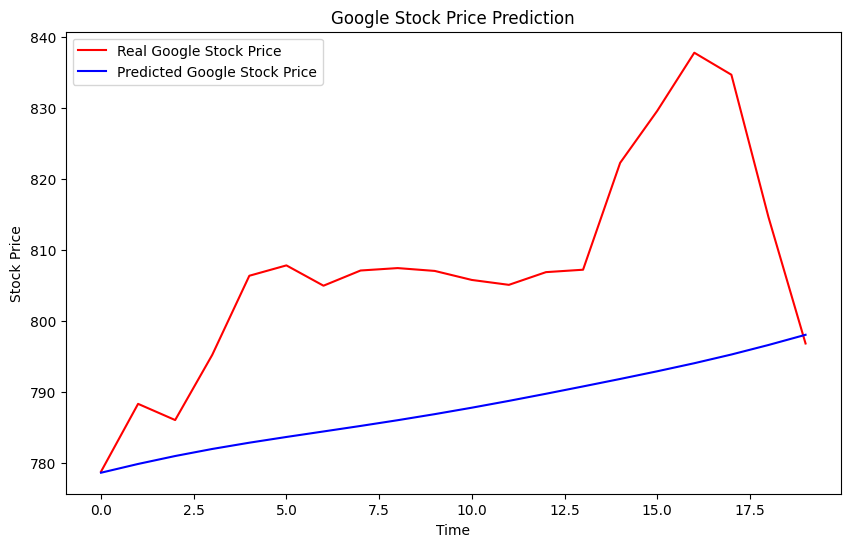

Mean Absolute Error (MAE): 19.798990478515616
Root Mean Squared Error (RMSE): 22.794145201533453


In [38]:
y_pred = model.predict(X_test)

# Inverse transform predictions and test labels to their original scale
y_pred = sc.inverse_transform(y_pred.reshape(-1, 1))
y_test = sc.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs. predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='red', label='Real Google Stock Price')
plt.plot(y_pred, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Evaluate the model with Mean Absolute Error (MAE) or Root Mean Square Error (RMSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
